### Ensemble of models
- SARIMAX
- XGB 
- GRU (IP)


### Imports & Standard procedures

In [2]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# RMSE and R^2 
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split as tts 
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler


# fitting ARIMA
import pmdarima as pm 
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# XGB regressor
from sklearn.ensemble import GradientBoostingRegressor

# GRU model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping

from itertools import product

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

# Suppress specific warnings
warnings.simplefilter("ignore", category=ValueWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

# (Optional) suppress sklearn warnings too
from sklearn.exceptions import ConvergenceWarning as SklearnConvergenceWarning
warnings.simplefilter("ignore", category=SklearnConvergenceWarning)

pd.set_option('display.max_columns', None)

# Show full width of each column
pd.set_option('display.max_colwidth', None)

### Read data in

In [353]:
# For forecasting on new data 2020-2024 to forecast on 2024

# For running on local machine, remove the path and just run the files individually - ie. removing Stats 170 Market Hotness/Datasets...
#full_df = pd.read_csv('../Stats 170 Market Hotness/Datasets/NewTransactionData.csv') 

# For pure training 
train_df = pd.read_csv('../Stats 170 Market Hotness/Datasets/hotness_index_train2.csv')

# For pure testing / validation for forecasting 
test_df = pd.read_csv('../Stats 170 Market Hotness/Datasets/hotness_index_test2.csv')

model_features_df = pd.read_csv('/Users/ms/Desktop/Stats 170a/Stats 170 Market Hotness/models_df_wlags.csv')


In [532]:
print(train_df['Year'].min())


print(train_df['Year'].max())


2020
2024


In [528]:
print(test_df['Year'].min())
print(test_df['Month'].min())


print(test_df['Year'].max())
print(test_df['Month'].max())

2024
9
2024
12


In [160]:
train_df.head()

,cntycd,Year,Month,med_dom,avg_salelistratio,n,prior_salelistratio,prior_dom,prior_absorption_rate,absorption_rate,weight,adj_avg_salelistratio,adj_med_dom,adj_absorption_rate,date,scaled_salelistratio,scaled_dom,scaled_absorption,raw_hotness,hotness_index
0,6001,2020,2,12.0,1.109423,755,1.248571,13,0.457198,0.032934,0.961783,1.114741,12.038217,0.049148,2020-02-01,1.500000,0.778582,0.049148,2.327730,83.229327
1,6001,2020,3,13.0,1.050983,717,1.248571,13,0.457198,0.341564,0.959839,1.058918,13.000000,0.346208,2020-03-01,0.969771,0.755124,0.346208,2.071103,77.666765
2,6001,2020,4,15.0,1.018582,664,1.248571,13,0.457198,0.456212,0.956772,1.028524,14.913545,0.456254,2020-04-01,0.657602,0.708452,0.456254,1.822308,72.273977
3,6001,2020,5,13.0,1.041108,799,1.248571,13,0.457198,0.353846,0.963812,1.048616,13.000000,0.357586,2020-05-01,0.863960,0.755124,0.357586,1.976670,75.619880
4,6001,2020,6,12.0,1.059627,1078,1.248571,13,0.457198,0.391008,0.972924,1.064743,12.027076,0.392800,2020-06-01,1.029594,0.778854,0.392800,2.201248,80.487742


In [161]:
test_df.head()

,cntycd,Year,Month,med_dom,avg_salelistratio,n,prior_salelistratio,prior_dom,prior_absorption_rate,absorption_rate,weight,adj_avg_salelistratio,adj_med_dom,adj_absorption_rate,date,scaled_salelistratio,scaled_dom,scaled_absorption,raw_hotness,hotness_index
0,6001,2024,9,0.0,0.000000,0,1.248571,13,0.457198,0,0.000000,1.248571,13.000000,0.457198,2024-09-01,1.500000,0.755124,0.660342,2.915466,95.968894
1,6001,2024,10,15.0,1.046040,1913,1.248571,13,0.457198,0,0.984560,1.049167,14.969120,0.007059,2024-10-01,0.869621,0.707096,-0.408750,1.167967,58.090702
2,6001,2024,11,14.5,1.051801,715,1.248571,13,0.457198,0,0.959732,1.059725,14.439597,0.018411,2024-11-01,0.978054,0.720012,-0.381790,1.316276,61.305388
3,6001,2024,12,12.0,1.038874,535,1.248571,13,0.457198,0,0.946903,1.050008,12.053097,0.024276,2024-12-01,0.878261,0.778219,-0.367859,1.288620,60.705939
4,6005,2024,9,0.0,0.000000,0,0.950000,60,0.000000,0,0.000000,0.950000,60.000000,0.000000,2024-09-01,-0.148877,-0.391218,-0.425516,-0.965610,11.844006


### Data Processing

In [ ]:
# For xgb
features = ['prior_salelistratio_lag_3', 'prior_dom_lag_3', 'hotness_index_lag_3', 'med_dom_lag_3',
                       'avg_salelistratio_lag_3', 'buildingareatotal_final_lag_3',
                       'closeprice_final_lag_3','cumulativedaysonmarket_final_lag_3', 
                       'yearbuilt_final_lag_3', 'property_tax_final_lag_3', 
                       'hpi_final_lag_3', 'CPI_final_lag_3'
             ]

# For sarimax
sfeatures = ['prior_salelistratio_lag_3', 'prior_dom_lag_3', 'hotness_index_lag_3', 'med_dom_lag_3',
                       'avg_salelistratio_lag_3', 'buildingareatotal_final_lag_3',
                       'closeprice_final_lag_3','cumulativedaysonmarket_final_lag_3', 
                       'yearbuilt_final_lag_3', 'property_tax_final_lag_3', 
                       'hpi_final_lag_3', 'CPI_final_lag_3'
]

# Step 1: Define features and target 
gfeatures = ['prior_salelistratio_lag_3', 'prior_dom_lag_3', 'hotness_index_lag_3', 'med_dom_lag_3',
                       'avg_salelistratio_lag_3', 'buildingareatotal_final_lag_3',
                       'closeprice_final_lag_3','cumulativedaysonmarket_final_lag_3', 
                       'yearbuilt_final_lag_3', 'property_tax_final_lag_3', 
                       'hpi_final_lag_3', 'CPI_final_lag_3']

num_features = len(gfeatures)

feature_cols = [col for col in model_features_df.columns if col in gfeatures]

X_data = []
y_data = []
seq_length = 1  # use past 12 months to predict next month's hotness_index

# In time series forecasting (especially housing/market data), patterns like:
# Seasonality, Annual cycles, Lagged macro trends (e.g., interest rates, absorption, DOM)
# often repeat over year-long intervals.

# A 12-month lookback window helps the model:
# 1. Understand annual price cycles.
# 2. Learn temporal dependencies over a realistic timeframe.

# Scale features
scaler = MinMaxScaler()
X_raw_all = model_features_df[feature_cols].values
scaler.fit(X_raw_all) 

# Set up Train - Test - Split
edf_x = model_features_df.copy()
edf_y = model_features_df.copy()

# Ensure 'date' is datetime
edf_x['date'] = pd.to_datetime(edf_x['date'])
edf_y['date'] = pd.to_datetime(edf_y['date'])



### Train test split

In [310]:
# train test split 
etrain = edf_x
etest = edf_y

#print(etrain.columns)
#print(etest.columns)

# NOTE: IF RUNNING INTO "date" issues: 
# KeyError: "None of ['date'] are in the columns"
# Please run the previous block then run again

# Setup train and test for each model 

# SARIMAX 
split_idx = int(0.9 * len(model_features_df))
X_train_sx, X_test_sx = etrain[:split_idx][sfeatures], etest[split_idx:][sfeatures]
y_train_sx, y_test_sx = etrain[:split_idx]['hotness_index'], etest[split_idx:]['hotness_index']

y_train_sx = pd.to_numeric(y_train_sx, errors='coerce')
X_train_sx = X_train_sx.apply(pd.to_numeric, errors='coerce')

y_test_sx = pd.to_numeric(y_train_sx, errors='coerce')
X_test_sx = X_train_sx.apply(pd.to_numeric, errors='coerce')


# xgb
X_train_xgb, X_test_xgb = etrain[:split_idx][features], etest[split_idx:][features]
y_train_xgb, y_test_xgb = etrain[:split_idx]['hotness_index'], etest[split_idx:]['hotness_index']

y_train_xgb = pd.to_numeric(y_train_sx, errors='coerce')
X_train_xgb = X_train_sx.apply(pd.to_numeric, errors='coerce')

y_test_xgb = pd.to_numeric(y_train_sx, errors='coerce')
X_test_xgb = X_train_sx.apply(pd.to_numeric, errors='coerce')

# GRU train test split - already covered 

# Need to trim 6 data points from sarimax and xgb to keep consistent with GRU 
X_train_sx = X_train_sx.iloc[1:].reset_index(drop=True)
y_train_sx = y_train_sx.iloc[1:].reset_index(drop=True)

X_train_xgb = X_train_xgb.iloc[1:].reset_index(drop=True)
y_train_xgb = y_train_xgb.iloc[1:].reset_index(drop=True)




In [311]:
# Step 1: Scale all data first
scaler = MinMaxScaler()
model_features_df[gfeatures] = scaler.fit_transform(model_features_df[gfeatures])

# Step 2: Split BEFORE sequence generation
split_idx = int(0.9 * len(model_features_df))
train_df = model_features_df[:split_idx]
test_df = model_features_df[split_idx:]

# Step 3: Function to generate GRU sequences
def make_gru_sequences(df, feature_list, seq_length=1):
    X_seq, y_seq = [], []
    X_raw = df[feature_list].values
    y_raw = df['hotness_index'].values
    for i in range(len(X_raw) - seq_length):
        X_seq.append(X_raw[i:i+seq_length])
        y_seq.append(y_raw[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# Step 4: Apply to both train and test
X_train_gru, y_train_gru = make_gru_sequences(train_df, gfeatures, seq_length)
X_test_gru, y_test_gru = make_gru_sequences(test_df, gfeatures, seq_length)

# Final shapes check
print("GRU Train shape:", X_train_gru.shape, y_train_gru.shape)
print("GRU Test shape:", X_test_gru.shape, y_test_gru.shape)

GRU Train shape: (1696, 1, 12) (1696,)
GRU Test shape: (188, 1, 12) (188,)


## Missing values sanity check
- make sure all dataframes have no NaN values. 
- if there is, make sure to fill with median of that column

In [312]:
print(X_train_gru.shape)
print(X_train_sx.shape)
print(X_train_xgb.shape)

(1696, 1, 12)
(1696, 12)
(1696, 12)


In [305]:
print(y_test_gru.shape)
print(y_test_sx.shape)
print(y_test_xgb.shape)

(188,)
(1697,)
(1697,)


In [293]:
print(np.isnan(X_train_gru).sum(), np.isinf(X_train_gru).sum())
print(np.isnan(y_train_gru).sum(), np.isinf(y_train_gru).sum())

print(np.isnan(X_test_gru).sum(), np.isinf(X_test_gru).sum())
print(np.isnan(y_test_gru).sum(), np.isinf(y_test_gru).sum())


0 0
0 0
0 0
0 0


In [294]:
print(X_train_sx.isnull().sum())  # Shows which columns have NaNs
print(X_train_xgb.isnull().sum())  # Shows which columns have NaNs



hotness_index_lag_3                   0
med_dom_lag_3                         0
avg_salelistratio_lag_3               0
prior_salelistratio_lag_3             0
prior_dom_lag_3                       0
buildingareatotal_final_lag_3         0
closeprice_final_lag_3                0
cumulativedaysonmarket_final_lag_3    0
yearbuilt_final_lag_3                 0
property_tax_final_lag_3              0
hpi_final_lag_3                       0
CPI_final_lag_3                       0
dtype: int64
hotness_index_lag_3                   0
med_dom_lag_3                         0
avg_salelistratio_lag_3               0
prior_salelistratio_lag_3             0
prior_dom_lag_3                       0
buildingareatotal_final_lag_3         0
closeprice_final_lag_3                0
cumulativedaysonmarket_final_lag_3    0
yearbuilt_final_lag_3                 0
property_tax_final_lag_3              0
hpi_final_lag_3                       0
CPI_final_lag_3                       0
dtype: int64


### Fit each model with previous optimal parameters

In [313]:
# 1. SARIMAX
sarimax_model = SARIMAX(y_train_sx, exog=X_train_sx, order=(0, 1, 1), enforce_stationarity=False, enforce_invertibility=False, random_state=1234)
sarimax_results = sarimax_model.fit(disp=False)
sarimax_preds_train = sarimax_results.fittedvalues
sarimax_preds_test = sarimax_results.get_forecast(steps=len(X_test_sx), exog=X_test_sx).predicted_mean

# GRU model here
GRUmodel = Sequential([
    Masking(mask_value=0.0, input_shape=(seq_length, num_features)),
    GRU(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

GRUmodel.compile(optimizer='adam', loss='mse', metrics=['mae'])
GRUmodel.fit(X_train_gru, y_train_gru, epochs=50, batch_size=16, validation_data=(X_test_gru, y_test_gru))
gru_preds_test = GRUmodel.predict(X_test_gru)

# 3. Gradient Boost
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=3, subsample=1)
gbr.fit(X_train_xgb, y_train_xgb)
gbr_preds_train = gbr.predict(X_train_xgb)
gbr_preds_test = gbr.predict(X_test_xgb)



/Users/ms/anaconda3/envs/cs178/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Epoch 1/50


/Users/ms/anaconda3/envs/cs178/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/ms/anaconda3/envs/cs178/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4928.6118 - mae: 66.6420 - val_loss: 1055.2161 - val_mae: 26.1840
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1582.0012 - mae: 33.6738 - val_loss: 747.3616 - val_mae: 23.4725
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 536.7575 - mae: 18.9510 - val_loss: 466.2607 - val_mae: 18.3343
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 393.7933 - mae: 15.9787 - val_loss: 315.3364 - val_mae: 14.9402
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 263.3830 - mae: 12.8957 - val_loss: 198.3864 - val_mae: 11.4208
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 231.7248 - mae: 11.9439 - val_loss: 169.8187 - val_mae: 10.2426
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 211.1717 - mae: 11.2929 - val_loss: 171.3885 - val_mae: 10.2910
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 207.6210 - mae: 11.3360 - val_loss: 168.7389 - val_mae: 10.1197
Epoch 9/50
106/1

In [296]:
r2_gru = r2_score(y_test_gru, gru_preds_test)
rmse_gru = root_mean_squared_error(y_test_gru, gru_preds_test)

print(f"R²: {r2_gru:.4f}")
print(f"RMSE: {rmse_gru:.2f}")

R²: 0.5375
RMSE: 13.22


In [297]:
print(sarimax_preds_test.shape)
print(gbr_preds_test.shape)
print(gru_preds_test.shape)


(1697,)
(1697,)
(188, 1)


### Weighted Average Evaluation:

In [317]:
# Define weights (adjust based on performance or intuition)
w_sarimax = 0.6
w_gbr = 0.4

# Weighted average ensemble
weighted_preds = (w_sarimax * sarimax_preds_test) + (w_gbr * gbr_preds_test) 

In [320]:
wa_rmse = root_mean_squared_error(y_test_sx, weighted_preds)
wa_r2 = r2_score(y_test_sx, weighted_preds)

print(f"Weighted Average Ensemble RMSE: {wa_rmse:.4f}")
print(f"Weighted Average Ensemble R²:   {wa_r2:.4f}")

print(f"GRU RMSE: {rmse_gru:.4f}")
print(f"GRU R²: {r2_gru:.4f}")


Weighted Average Ensemble RMSE: 10.2995
Weighted Average Ensemble R²:   0.7799
GRU RMSE: 13.2162
GRU R²: 0.5375


### Forecasting for 2025 
- Training on 2020 to 2024 data
- "Test" and validate on 2025 
- Optional (plot 95% CI?)

### Importing Train and Validation Data

In [177]:
# FOR FORECASTING 

# For pure training 
train_df = pd.read_csv('../Stats 170 Market Hotness/Datasets/hotness_index_train2.csv')

# 
test_df = pd.read_csv('../Stats 170 Market Hotness/Datasets/hotness_index_test2.csv')

model_features_df = pd.read_csv('/Users/ms/Desktop/Stats 170a/Stats 170 Market Hotness/models_df_wlags.csv')

hotness_index2 = pd.read_csv('/Users/ms/Desktop/Stats 170a/Stats 170 Market Hotness/Datasets/hotness_index_full2.csv')


In [178]:
hotness_index2[hotness_index2['Year'] == 2025].head()



,cntycd,Year,Month,med_dom,avg_salelistratio,n,prior_salelistratio,prior_dom,prior_absorption_rate,absorption_rate,weight,adj_avg_salelistratio,adj_med_dom,adj_absorption_rate,date,scaled_salelistratio,scaled_dom,scaled_absorption,raw_hotness,hotness_index


In [179]:
print(model_features_df['Year'].min())
print(model_features_df['Year'].max())

print(hotness_index2['Year'].min())
print(hotness_index2['Year'].max())

# This will be training set 
model_features_df.columns

2020
2024
2020
2024


Index(['Year', 'Month', 'cntycd', 'buildingareatotal_final',
       'closeprice_final', 'cumulativedaysonmarket_final', 'yearbuilt_final',
       'property_tax_final', 'hpi_final', 'CPI_final', 'Total.Revenues_final',
       'Estimated.Population_final', 'Revenues.Per.Capita_final', 'med_dom',
       'avg_salelistratio', 'n', 'prior_salelistratio', 'prior_dom',
       'prior_absorption_rate', 'absorption_rate', 'weight',
       'adj_avg_salelistratio', 'adj_med_dom', 'adj_absorption_rate', 'date',
       'scaled_salelistratio', 'scaled_dom', 'scaled_absorption',
       'raw_hotness', 'hotness_index', 'hotness_index_lag_1', 'med_dom_lag_1',
       'avg_salelistratio_lag_1', 'prior_salelistratio_lag_1',
       'prior_dom_lag_1', 'hotness_index_lag_3', 'med_dom_lag_3',
       'avg_salelistratio_lag_3', 'prior_salelistratio_lag_3',
       'prior_dom_lag_3', 'buildingareatotal_final_lag_1',
       'closeprice_final_lag_1', 'cumulativedaysonmarket_final_lag_1',
       'yearbuilt_final_lag_1'

In [190]:
final_df = pd.read_csv('/Users/ms/Desktop/Stats 170a/Stats 170 Market Hotness/final_datafile.csv')

# Ensure Month and Year columns are integers
final_df['Year'] = final_df['Year'].astype(int)
final_df['Month'] = final_df['Month'].astype(int)

# Train set: 2020 Feb (2020-02) to 2024 Aug (2024-08)
train_mask = (
    ((final_df['Year'] > 2020) | ((final_df['Year'] == 2020) & (final_df['Month'] >= 2))) &
    ((final_df['Year'] < 2024) | ((final_df['Year'] == 2024) & (final_df['Month'] <= 8)))
)
train_df = final_df[train_mask].copy()

# Test set: 2024 Sept (2024-09) to 2024 Dec (2024-12)
test_mask = (
    (final_df['Year'] == 2024) & (final_df['Month'] >= 9) & (final_df['Month'] <= 12)
)
test_df = final_df[test_mask].copy()


valid_mask = (
    (final_df['Year'] == 2025)
)

valid_df = final_df[valid_mask].copy()

final_df.head()


,cntycd,Year,Month,med_dom,avg_salelistratio,n,prior_salelistratio,prior_dom,prior_absorption_rate,absorption_rate,weight,adj_avg_salelistratio,adj_med_dom,adj_absorption_rate,date,scaled_salelistratio,scaled_dom,scaled_absorption,raw_hotness,hotness_index,buildingareatotal_final,closeprice_final,cumulativedaysonmarket_final,yearbuilt_final,property_tax_final,hpi_final,CPI_final,Total.Revenues_final,Estimated.Population_final,Revenues.Per.Capita_final,hotness_index_lag_1,hotness_index_lag_3,med_dom_lag_1,med_dom_lag_3,avg_salelistratio_lag_1,avg_salelistratio_lag_3,prior_salelistratio_lag_1,prior_salelistratio_lag_3,prior_dom_lag_1,prior_dom_lag_3,buildingareatotal_final_lag_1,buildingareatotal_final_lag_3,closeprice_final_lag_1,closeprice_final_lag_3,cumulativedaysonmarket_final_lag_1,cumulativedaysonmarket_final_lag_3,yearbuilt_final_lag_1,yearbuilt_final_lag_3,property_tax_final_lag_1,property_tax_final_lag_3,hpi_final_lag_1,hpi_final_lag_3,CPI_final_lag_1,CPI_final_lag_3,Total.Revenues_final_lag_1,Total.Revenues_final_lag_3,Estimated.Population_final_lag_1,Estimated.Population_final_lag_3,Revenues.Per.Capita_final_lag_1,Revenues.Per.Capita_final_lag_3
0,6001,2020,2,12.0,1.109423,755.0,1.240659,13.0,0.457198,0.032934,0.961783,1.114439,12.038217,0.049148,2020-02-01,1.500000,0.806502,0.049148,2.355650,83.477645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.477645,83.477645,12.0,12.0,1.109423,1.109423,1.240659,1.240659,13.0,13.0,1663.346282,NaN,1.274875e+06,NaN,13.044893,NaN,1966.245283,NaN,931217054.0,NaN,967.68,NaN,335.989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6001,2020,3,13.0,1.050983,717.0,1.240659,13.0,0.457198,0.341564,0.959839,1.058601,13.000000,0.346208,2020-03-01,1.038707,0.782494,0.346208,2.167409,79.469662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.477645,83.477645,12.0,12.0,1.109423,1.109423,1.240659,1.240659,13.0,13.0,1663.346282,NaN,1.274875e+06,NaN,13.044893,NaN,1966.245283,NaN,931217054.0,NaN,967.68,NaN,335.989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6001,2020,4,15.0,1.018582,664.0,1.240659,13.0,0.457198,0.456212,0.956772,1.028182,14.913545,0.456254,2020-04-01,0.705220,0.734729,0.456254,1.896203,73.695216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.469662,83.477645,13.0,12.0,1.050983,1.109423,1.240659,1.240659,13.0,13.0,1663.346282,NaN,1.274875e+06,NaN,13.044893,NaN,1966.245283,NaN,931217054.0,NaN,967.68,NaN,335.989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6001,2020,5,13.0,1.041108,799.0,1.240659,13.0,0.457198,0.353846,0.963812,1.048330,13.000000,0.357586,2020-05-01,0.926105,0.782494,0.357586,2.066186,77.314437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.695216,83.477645,15.0,12.0,1.018582,1.109423,1.240659,1.240659,13.0,13.0,1663.346282,NaN,1.274875e+06,NaN,13.044893,NaN,1966.245283,NaN,931217054.0,NaN,967.68,NaN,335.989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6001,2020,6,12.0,1.059627,1078.0,1.240659,13.0,0.457198,0.391008,0.972924,1.064529,12.027076,0.392800,2020-06-01,1.103699,0.806780,0.392800,2.303279,82.362572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.314437,79.469662,13.0,13.0,1.041108,1.050983,1.240659,1.240659,13.0,13.0,1663.346282,NaN,1.274875e+06,NaN,13.044893,NaN,1966.245283,NaN,931217054.0,NaN,967.68,NaN,335.989,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:

print(train_df['Year'].min())
print(train_df['Year'].max())
print(test_df['Year'].min())
print(test_df['Year'].max())

print(final_df['Year'].min())
print(final_df['Year'].max())

print(valid_df['Year'].min())
print(valid_df['Year'].max())




2020
2024
2024
2024
2020
2025
2025
2025


In [192]:
# Example: keep only these columns
keep = ['cntycd', 'Year', 'Month', 'hotness_index','hotness_index_lag_1', 'med_dom_lag_1', 'buildingareatotal_final_lag_1', 'closeprice_final_lag_1', 'cumulativedaysonmarket_final_lag_1', 
        'yearbuilt_final_lag_1', 'property_tax_final_lag_1', 'hpi_final_lag_1', 'CPI_final_lag_1', 'avg_salelistratio_lag_1', 'prior_salelistratio_lag_1', 'prior_dom_lag_1',
        
        'hotness_index_lag_3', 'med_dom_lag_3', 'avg_salelistratio_lag_3', 'prior_salelistratio_lag_3', 'prior_dom_lag_3']


train_df = train_df[keep]
test_df = test_df[keep]

valid_df = valid_df[keep]

print(train_df.columns)
print("---------------------------------------------")

print(test_df.columns)

print("---------------------------------------------")

print(valid_df.columns)



Index(['cntycd', 'Year', 'Month', 'hotness_index', 'hotness_index_lag_1',
       'med_dom_lag_1', 'buildingareatotal_final_lag_1',
       'closeprice_final_lag_1', 'cumulativedaysonmarket_final_lag_1',
       'yearbuilt_final_lag_1', 'property_tax_final_lag_1', 'hpi_final_lag_1',
       'CPI_final_lag_1', 'avg_salelistratio_lag_1',
       'prior_salelistratio_lag_1', 'prior_dom_lag_1', 'hotness_index_lag_3',
       'med_dom_lag_3', 'avg_salelistratio_lag_3', 'prior_salelistratio_lag_3',
       'prior_dom_lag_3'],
      dtype='object')
---------------------------------------------
Index(['cntycd', 'Year', 'Month', 'hotness_index', 'hotness_index_lag_1',
       'med_dom_lag_1', 'buildingareatotal_final_lag_1',
       'closeprice_final_lag_1', 'cumulativedaysonmarket_final_lag_1',
       'yearbuilt_final_lag_1', 'property_tax_final_lag_1', 'hpi_final_lag_1',
       'CPI_final_lag_1', 'avg_salelistratio_lag_1',
       'prior_salelistratio_lag_1', 'prior_dom_lag_1', 'hotness_index_lag_3',
 

In [193]:
for col in [keep]:
    
    # Try filling with county-level median
    train_df[col] = train_df.groupby('cntycd')[col].transform(
        lambda x: x.fillna(x.median())
    )
    
    # Fill any remaining NaNs (where county median was not available) with global median
    train_df[col] = train_df[col].fillna(train_df[col].median())
    
     # Try filling with county-level median
    test_df[col] = test_df.groupby('cntycd')[col].transform(
        lambda x: x.fillna(x.median())
    )
    
    # Fill any remaining NaNs (where county median was not available) with global median
    test_df[col] = test_df[col].fillna(test_df[col].median())
    
    # Try filling with county-level median
    valid_df[col] = valid_df.groupby('cntycd')[col].transform(
        lambda x: x.fillna(x.median())
    )
    
    # Fill any remaining NaNs (where county median was not available) with global median
    valid_df[col] = valid_df[col].fillna(valid_df[col].median())
    

In [194]:
print(train_df.isna().sum())
print()
print(test_df.isna().sum())
print()
valid_df = valid_df.drop(columns='hotness_index')

print(valid_df.isna().sum())



cntycd                                0
Year                                  0
Month                                 0
hotness_index                         0
hotness_index_lag_1                   0
med_dom_lag_1                         0
buildingareatotal_final_lag_1         0
closeprice_final_lag_1                0
cumulativedaysonmarket_final_lag_1    0
yearbuilt_final_lag_1                 0
property_tax_final_lag_1              0
hpi_final_lag_1                       0
CPI_final_lag_1                       0
avg_salelistratio_lag_1               0
prior_salelistratio_lag_1             0
prior_dom_lag_1                       0
hotness_index_lag_3                   0
med_dom_lag_3                         0
avg_salelistratio_lag_3               0
prior_salelistratio_lag_3             0
prior_dom_lag_3                       0
dtype: int64

cntycd                                0
Year                                  0
Month                                 0
hotness_index             

### Feature Selection (USING ONLY SARIMAX, XGB, and GRU for FORECAST)
- and sort by date as index

In [195]:
# For xgb & SARIMAX - no NaN features
features = ['hotness_index_lag_1', 'med_dom_lag_1', 'buildingareatotal_final_lag_1', 'closeprice_final_lag_1', 'cumulativedaysonmarket_final_lag_1', 
        'yearbuilt_final_lag_1', 'property_tax_final_lag_1', 'hpi_final_lag_1', 'CPI_final_lag_1', 'avg_salelistratio_lag_1', 'prior_salelistratio_lag_1', 'prior_dom_lag_1',
        
        'hotness_index_lag_3', 'med_dom_lag_3', 'avg_salelistratio_lag_3', 'prior_salelistratio_lag_3', 'prior_dom_lag_3']


num_features = len(features)

feature_cols = [col for col in model_features_df.columns if col in features]

X_data = []
y_data = []
seq_length = 6

# Scale features
scaler1 = MinMaxScaler()
edf_y = test_df[['Year', 'Month', 'cntycd', 'hotness_index'] + features].values # 2024 sept to dec
edf_x = train_df[['Year', 'Month', 'cntycd', 'hotness_index'] + features].values # 2020-2024 aug values
edf_z = valid_df[['Year', 'Month', 'cntycd'] + features].values # 2020-2024 aug values
scaler1.fit(edf_x) 
scaler1.fit(edf_y)


# Ensure 'date' is datetime
#edf_x['date'] = pd.to_datetime(edf_x['date'])
#edf_y['date'] = pd.to_datetime(edf_y['date'])

MinMaxScaler()

In [127]:

# Step 3: Function to generate GRU sequences
def make_gru_sequences(df, feature_list, seq_length=1):
    X_seq, y_seq = [], []
    X_raw = df[features].values
    y_raw = df['hotness_index'].values
    for i in range(len(X_raw) - seq_length):
        X_seq.append(X_raw[i:i+seq_length])
        y_seq.append(y_raw[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# Step 4: Apply to both train and test
X_train_gru, y_train_gru = make_gru_sequences(train_df, features, seq_length)
X_test_gru, y_test_gru = make_gru_sequences(test_df, features, seq_length)

# Final shapes check
print("GRU Train shape:", X_train_gru.shape, y_train_gru.shape)
print("GRU Test shape:", X_test_gru.shape, y_test_gru.shape)

GRU Train shape: (3129, 6, 17) (3129,)
GRU Test shape: (222, 6, 17) (222,)


In [130]:
# GRU model here
GRUmodel = Sequential([
    Masking(mask_value=0.0, input_shape=(seq_length, num_features)),
    GRU(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

GRUmodel.compile(optimizer='adam', loss='mse', metrics=['mae'])
GRUmodel.fit(X_train_gru, y_train_gru, epochs=50, batch_size=16, validation_data=(X_test_gru, y_test_gru))
gru_preds_test = GRUmodel.predict(X_test_gru)

Epoch 1/50


/Users/ms/anaconda3/envs/cs178/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2412.7883 - mae: 40.6969 - val_loss: 647.6992 - val_mae: 18.9253
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 920.8756 - mae: 24.3003 - val_loss: 533.0176 - val_mae: 21.1907
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 830.5842 - mae: 25.2985 - val_loss: 527.6785 - val_mae: 21.0109
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 779.5154 - mae: 24.5005 - val_loss: 528.2266 - val_mae: 21.0384
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 780.3080 - mae: 24.3762 - val_loss: 539.0634 - val_mae: 21.3894
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 775.9757 - mae: 24.3839 - val_loss: 536.7937 - val_mae: 21.3243
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 821.9539 - mae: 25.1687 - val_loss: 536.4075 - val_mae: 21.3144
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 791.8655 - mae: 24.8969 - val_loss: 521.0946 - val_mae: 20.7723
Epoch 9/50
196/196

In [131]:
r2_gru = r2_score(y_test_gru, gru_preds_test)
rmse_gru = root_mean_squared_error(y_test_gru, gru_preds_test)

print(f"R²: {r2_gru:.4f}")
print(f"RMSE: {rmse_gru:.2f}")

R²: -0.0451
RMSE: 23.21


### Train Test Split

In [199]:
# train test split 
etrain = edf_x
etest = edf_y
evalid = edf_z

#print(type(etrain))
#print(type(etest))

print(etest.shape)
print(etrain.shape)
print(evalid.shape)

print(len(features))

etrain = pd.DataFrame(etrain, columns=['Year', 'Month', 'cntycd','hotness_index'] + features)  
etest = pd.DataFrame(etest, columns=['Year', 'Month', 'cntycd', 'hotness_index'] + features)
evalid = pd.DataFrame(evalid, columns=['Year', 'Month', 'cntycd'] + features)



#print(etrain.columns)
#print(etest.columns)

# NOTE: IF RUNNING INTO "date" issues: 
# KeyError: "None of ['date'] are in the columns"
# Please run the previous block then run again

# Setup train and test for each model 

# SARIMAX & XGB - will use the same data 
X_train_sxf, X_test_sxf = etrain[features], etest[features]
y_train_sxf, y_test_sxf = etrain['hotness_index'], etest['hotness_index']

y_train_sxf = pd.to_numeric(y_train_sxf, errors='coerce')
X_train_sxf = X_train_sxf.apply(pd.to_numeric, errors='coerce')

y_test_sxf = pd.to_numeric(y_test_sxf, errors='coerce')
X_test_sxf = X_test_sxf.apply(pd.to_numeric, errors='coerce')

forecast_features = evalid[features].copy()


print(X_train_sxf.shape, X_test_sxf.shape, forecast_features.shape)


(228, 21)
(3135, 21)
(76, 20)
17
(3135, 17) (228, 17) (76, 17)


In [200]:
num_unique_counties = etrain['cntycd'].nunique()
print("Number of unique counties:", num_unique_counties)

num_unique_counties = etest['cntycd'].nunique()
print("Number of unique counties:", num_unique_counties)

num_unique_counties = evalid['cntycd'].nunique()
print("Number of unique counties:", num_unique_counties)


Number of unique counties: 57
Number of unique counties: 57
Number of unique counties: 41


In [201]:
# 1. SARIMAX
sarimax_model = SARIMAX(y_train_sxf, exog=X_train_sxf, order=(0, 1, 1), enforce_stationarity=False, enforce_invertibility=False, random_state=1234)
sarimax_results = sarimax_model.fit(disp=False)
sarimax_preds_train = sarimax_results.fittedvalues
sarimax_preds_test = sarimax_results.get_forecast(steps=len(X_test_sxf), exog=X_test_sxf).predicted_mean

# For test set
y_test_sxf_trimmed = y_test_sxf.iloc[:len(sarimax_preds_test)]  # Match length

r2_test = r2_score(y_test_sxf_trimmed, sarimax_preds_test)
rmse_test = root_mean_squared_error(y_test_sxf_trimmed, sarimax_preds_test)

print(f"Test R²: {r2_test:.4f}, RMSE: {rmse_test:.4f}")



/Users/ms/anaconda3/envs/cs178/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Test R²: 0.6284, RMSE: 13.9322


/Users/ms/anaconda3/envs/cs178/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [202]:
# Forecast future steps
n_future = len(forecast_features)

sarimax_forecast_future = sarimax_results.get_forecast(steps=n_future, exog=forecast_features)
future_preds = sarimax_forecast_future.predicted_mean  # Series of predicted hotness_index

# Optional: Confidence Intervals
conf_int = sarimax_forecast_future.conf_int()

# View results
print("Forecasted hotness_index:")
print(future_preds)

Forecasted hotness_index:
3135    81.474015
3136    69.262262
3137    70.867568
3138    75.165494
3139    71.012714
          ...    
3206    64.225577
3207    59.322037
3208    50.596427
3209    31.486417
3210    28.871259
Name: predicted_mean, Length: 76, dtype: float64


/Users/ms/anaconda3/envs/cs178/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [203]:
# Make sure this DataFrame has 3 rows of exogenous features for future months
future_3months_exog = forecast_features.iloc[:3]

# Forecast next 3 months
sarimax_forecast_3mo = sarimax_results.get_forecast(steps=3, exog=future_3months_exog)
forecast_3mo_values = sarimax_forecast_3mo.predicted_mean
forecast_3mo_ci = sarimax_forecast_3mo.conf_int()

# Output
print("Next 3-month forecast (SARIMAX):")
print(forecast_3mo_values)


Next 3-month forecast (SARIMAX):
3135    81.474015
3136    69.262262
3137    70.867568
Name: predicted_mean, dtype: float64


In [210]:
forecast_features1 = evalid[features + ['cntycd', 'Year', 'Month']].copy()


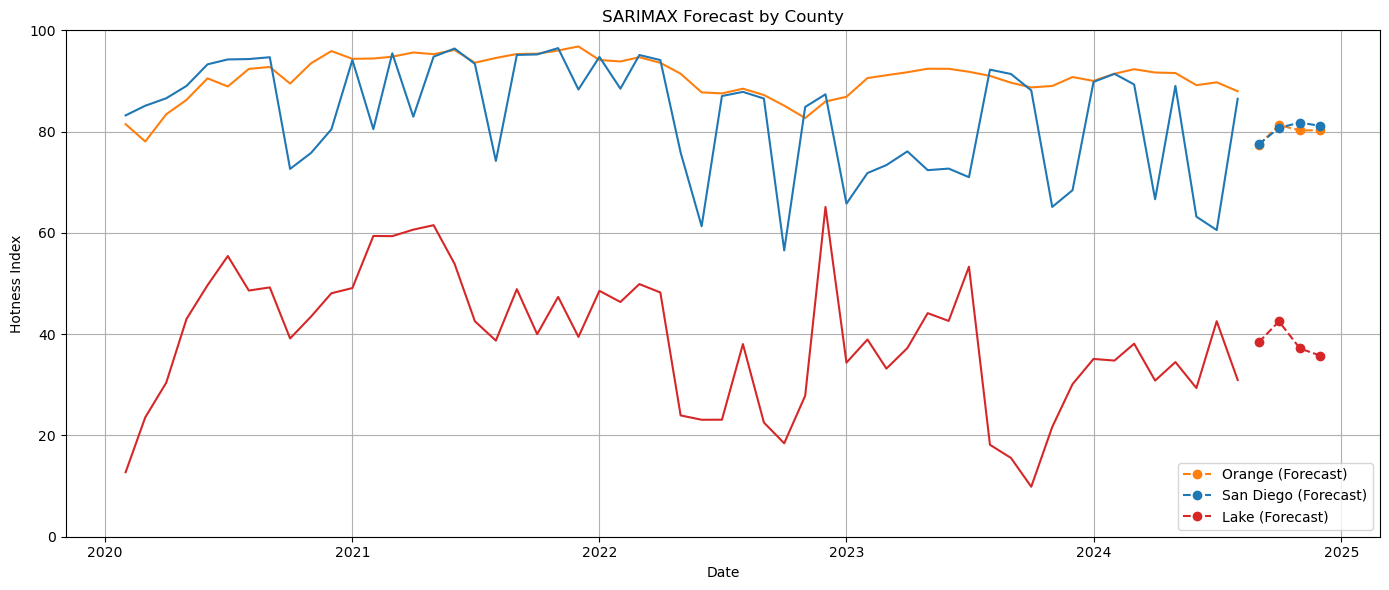

In [204]:
counties_to_plot = [6059, 6073, 6033]  # LA, Orange, San Diego

# Map county code to name and color
county_info = {
    #6037: {'name': 'Los Angeles', 'color': 'tab:blue'},
    6059: {'name': 'Orange', 'color': 'tab:orange'},
    6073: {'name': 'San Diego', 'color': 'tab:blue'},
    #6001: {'name': 'Alameda', 'color': 'tab:red'},
    #6111: {'name': 'Ventura', 'color': 'tab:pink'}
    #6115: {'name': 'Yuba', 'color': 'tab:red'}
    6033: {'name': 'Lake', 'color': 'tab:red'}
}

# Ensure 'date' exists
etrain1 = etrain.copy()
etrain1['date'] = pd.to_datetime(etrain1[['Year', 'Month']].assign(DAY=1))
train_subset = etrain1[etrain1['cntycd'].isin(counties_to_plot)]

etest = etest.iloc[:len(sarimax_preds_test)].copy()
etest['sarimax_forecast'] = sarimax_preds_test.values
etest['date'] = pd.to_datetime(etest[['Year', 'Month']].assign(DAY=1))
test_subset1 = etest[etest['cntycd'].isin(counties_to_plot)]

# Plot
plt.figure(figsize=(14, 6))
for county in counties_to_plot:
    info = county_info[county]
    color = info['color']
    name = info['name']

    train_group = train_subset[train_subset['cntycd'] == county]
    plt.plot(train_group['date'], train_group['hotness_index'], color=color)

    test_group1 = test_subset1[test_subset1['cntycd'] == county]
    plt.plot(test_group1['date'], test_group1['sarimax_forecast'], label=f'{name} (Forecast)', color=color, linestyle='--', marker='o')

plt.ylim(0, 100)
plt.xlabel("Date")
plt.ylabel("Hotness Index")
plt.title("SARIMAX Forecast by County")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [206]:
forecast_features.columns

Index(['hotness_index_lag_1', 'med_dom_lag_1', 'buildingareatotal_final_lag_1',
       'closeprice_final_lag_1', 'cumulativedaysonmarket_final_lag_1',
       'yearbuilt_final_lag_1', 'property_tax_final_lag_1', 'hpi_final_lag_1',
       'CPI_final_lag_1', 'avg_salelistratio_lag_1',
       'prior_salelistratio_lag_1', 'prior_dom_lag_1', 'hotness_index_lag_3',
       'med_dom_lag_3', 'avg_salelistratio_lag_3', 'prior_salelistratio_lag_3',
       'prior_dom_lag_3'],
      dtype='object')

In [212]:
future_forecasts = []

for county in counties_to_plot:
    # Get future exogenous variables for this county
    county_exog = forecast_features1[forecast_features1['cntycd'] == county].copy()

    # Ensure it's sorted chronologically and exactly 3 rows
    county_exog = county_exog.sort_values(['Year', 'Month']).iloc[:2]

    # Predict using SARIMAX
    forecast_result = sarimax_results.get_forecast(steps=2, exog=county_exog[features])
    county_preds = forecast_result.predicted_mean.values

    # Build a DataFrame for plotting
    forecast_dates = pd.to_datetime(county_exog[['Year', 'Month']].assign(DAY=1))
    county_df = pd.DataFrame({
        'date': forecast_dates,
        'sarimax_forecast': county_preds,
        'cntycd': county
    })
    future_forecasts.append(county_df)

# Combine into one validation DataFrame
validation_group = pd.concat(future_forecasts, ignore_index=True)


/Users/ms/anaconda3/envs/cs178/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/ms/anaconda3/envs/cs178/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/ms/anaconda3/envs/cs178/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


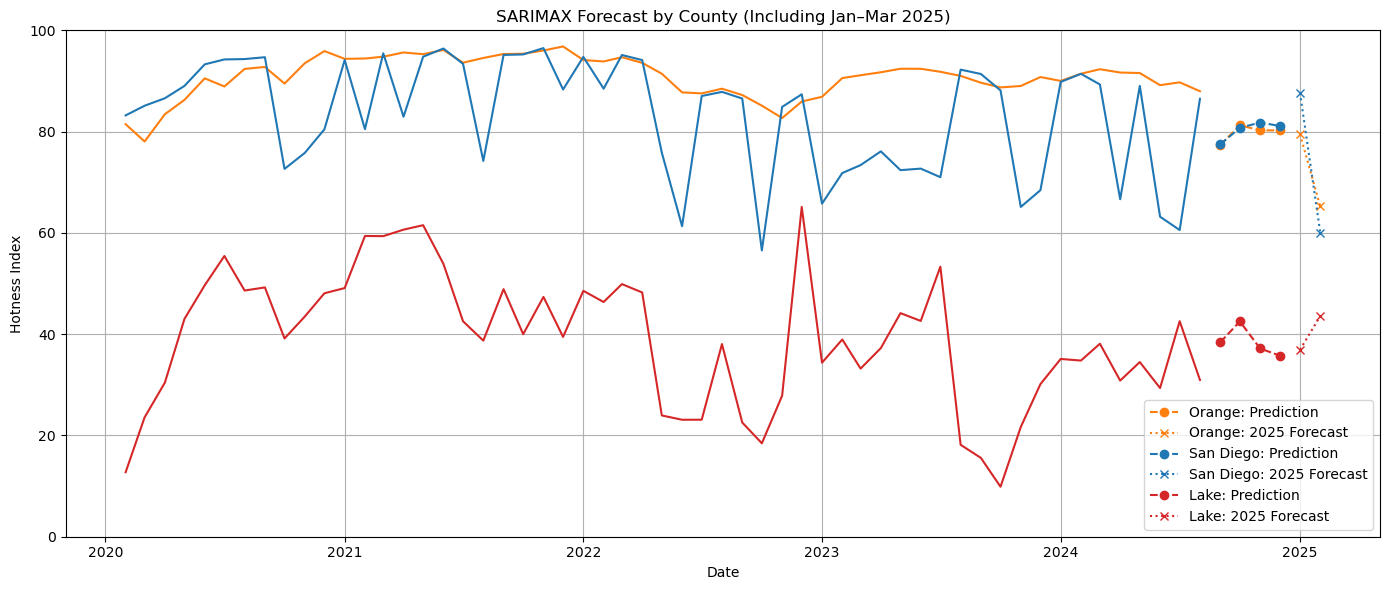

In [214]:
plt.figure(figsize=(14, 6))
for county in counties_to_plot:
    info = county_info[county]
    color = info['color']
    name = info['name']

    # Training actuals
    train_group = train_subset[train_subset['cntycd'] == county]
    plt.plot(train_group['date'], train_group['hotness_index'], color=color)

    # Test forecasts
    test_group1 = test_subset1[test_subset1['cntycd'] == county]
    plt.plot(test_group1['date'], test_group1['sarimax_forecast'],
             label=f'{name}: Prediction', color=color, linestyle='--', marker='o')

    # Future validation forecasts
    val_group = validation_group[validation_group['cntycd'] == county]
    plt.plot(val_group['date'], val_group['sarimax_forecast'],
             label=f'{name}: 2025 Forecast', color=color, linestyle=':', marker='x')

plt.ylim(0, 100)
plt.xlabel("Date")
plt.ylabel("Hotness Index")
plt.title("SARIMAX Forecast by County (Including Jan–Mar 2025)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [136]:
def forecast_3_months_xgb(model, initial_row, feature_cols):
    """
    Forecast next 3 months using a trained GradientBoostingRegressor model.

    Parameters:
    - model: Trained GradientBoostingRegressor
    - initial_row: Latest row of feature values (as Series)
    - feature_cols: List of model input features
    - global_df: Full training DataFrame used to compute medians for NaN handling

    Returns:
    - List of 3 predicted values
    """
    predictions = []
    current_row = initial_row.copy()

    for _ in range(3):
        # Create input DataFrame
        input_df = pd.DataFrame([current_row[feature_cols].values], columns=feature_cols)

        for col in [features]:
         # Fill any remaining NaNs (where county median was not available) with global median
            input_df[col] = input_df[col].fillna(input_df[col].median())

        # Predict
        next_pred = model.predict(input_df)[0]
        predictions.append(next_pred)

        # Shift lag features for next prediction
        if 'hotness_index_lag_1' in feature_cols:
            current_row['hotness_index_lag_1'] = next_pred
    

    return predictions


In [137]:
latest_row = X_test_sxf.iloc[-1].copy()

# 2. Gradient Boost
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=3, subsample=1)
gbr.fit(X_train_sxf, y_train_sxf)

gbr_preds_train = gbr.predict(X_train_sxf)
gbr_preds_test = gbr.predict(X_test_sxf)

forecast = forecast_3_months_xgb(
    model=gbr,  # your trained GradientBoostingRegressor
    initial_row=latest_row,
    feature_cols=features  # same features used for training
)

print("Hotness Index Forecast (Next 3 Months):", forecast)


Hotness Index Forecast (Next 3 Months): [29.297608893138705, 30.76273763784598, 30.791622248194088]


In [216]:
latest_row1 = forecast_features1.iloc[-1].copy()

# 2. Gradient Boost
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=3, subsample=1)
gbr.fit(X_train_sxf, y_train_sxf)

gbr_preds_train1 = gbr.predict(X_train_sxf)
gbr_preds_test1 = gbr.predict(X_test_sxf)

forecast1 = forecast_3_months_xgb(
    model=gbr,  # your trained GradientBoostingRegressor
    initial_row=latest_row1,
    feature_cols=features  # same features used for training
)

print("Hotness Index Forecast (Next 3 Months):", forecast1)


Hotness Index Forecast (Next 3 Months): [30.254407488973914, 30.254407488973914, 30.254407488973914]


In [138]:
# Ensure trimmed lengths match
y_test_sxf_trimmed = y_test_sxf.iloc[:len(gbr_preds_test)]

# Compute metrics
r2_test_gbr = r2_score(y_test_sxf_trimmed, gbr_preds_test)
rmse_test_gbr = root_mean_squared_error(y_test_sxf_trimmed, gbr_preds_test)

print(f"GBR Test R²: {r2_test_gbr:.4f}, RMSE: {rmse_test_gbr:.4f}")


GBR Test R²: 0.8996, RMSE: 7.2412


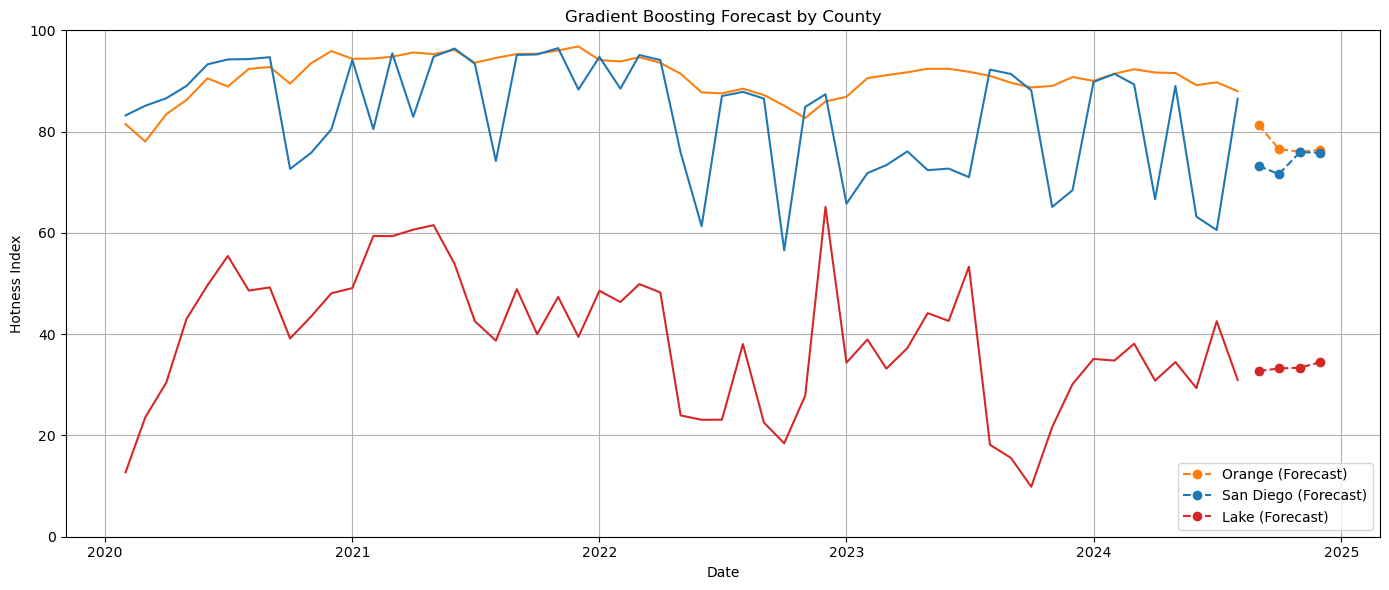

In [139]:
counties_to_plot = [6059, 6073, 6033]  # Orange, San Diego, Lake

# County info (color and name)
county_info = {
    6059: {'name': 'Orange', 'color': 'tab:orange'},
    6073: {'name': 'San Diego', 'color': 'tab:blue'},
    6033: {'name': 'Lake', 'color': 'tab:red'}
}

# Prepare training set
etrain1 = etrain.copy()
etrain1['date'] = pd.to_datetime(etrain1[['Year', 'Month']].assign(DAY=1))
train_subset = etrain1[etrain1['cntycd'].isin(counties_to_plot)]

# Prepare test set
etest = etest.copy()
etest['gbr_forecast'] = gbr_preds_test[:len(etest)]
etest['date'] = pd.to_datetime(etest[['Year', 'Month']].assign(DAY=1))
test_subset = etest[etest['cntycd'].isin(counties_to_plot)]

# Plot
plt.figure(figsize=(14, 6))
for county in counties_to_plot:
    info = county_info[county]
    color = info['color']
    name = info['name']

    train_group = train_subset[train_subset['cntycd'] == county]
    plt.plot(train_group['date'], train_group['hotness_index'], color=color)

    test_group = test_subset[test_subset['cntycd'] == county]
    plt.plot(test_group['date'], test_group['gbr_forecast'], label=f'{name} (Forecast)', color=color, linestyle='--', marker='o')

plt.ylim(0, 100)
plt.xlabel("Date")
plt.ylabel("Hotness Index")
plt.title("Gradient Boosting Forecast by County")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [142]:
# Weighted average
w_sarimax = 0.8
w_xgb = 0.2


ensemble_preds = w_sarimax * sarimax_preds_test + w_xgb * gbr_preds_test

# Ensure both forecasts are Series and aligned
sarimax_series = test_group1['sarimax_forecast']
xgb_series = test_group['gbr_forecast']

# Compute weighted average ensemble forecast
ensemble_forecast = w_sarimax * sarimax_series + w_xgb * xgb_series


y_test_trimmed = y_test_sxf.iloc[:len(ensemble_preds)]

r2_ensemble = r2_score(y_test_trimmed, ensemble_preds)
rmse_ensemble = root_mean_squared_error(y_test_trimmed, ensemble_preds)

print(f"Ensemble Test R²: {r2_ensemble:.4f}, RMSE: {rmse_ensemble:.4f}")

Ensemble Test R²: 0.7288, RMSE: 11.9028


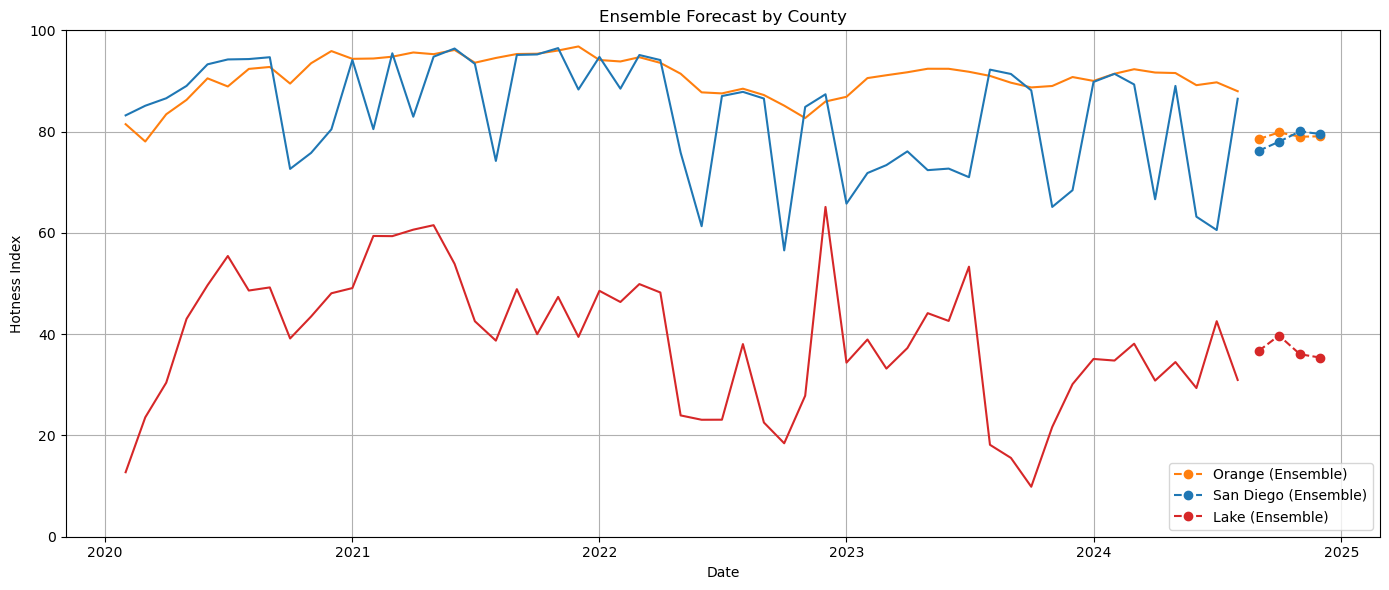

In [ ]:
# Parameters
counties_to_plot = [6059, 6073, 6033]  # Orange, San Diego, Lake

county_info = {
    6059: {'name': 'Orange', 'color': 'tab:orange'},
    6073: {'name': 'San Diego', 'color': 'tab:blue'},
    6033: {'name': 'Lake', 'color': 'tab:red'}
}

# Add date to training set
etrain1 = etrain.copy()
etrain1['date'] = pd.to_datetime(etrain1[['Year', 'Month']].assign(DAY=1))
train_subset = etrain1[etrain1['cntycd'].isin(counties_to_plot)]

# Add ensemble forecast to test set
etest = etest.copy()
etest['ensemble_forecast'] = ensemble_preds[:len(etest)].values  # ensure correct length
etest['date'] = pd.to_datetime(etest[['Year', 'Month']].assign(DAY=1))
test_subset = etest[etest['cntycd'].isin(counties_to_plot)]

# Plot
plt.figure(figsize=(14, 6))
for county in counties_to_plot:
    info = county_info[county]
    color = info['color']
    name = info['name']

    # Training actuals
    train_group = train_subset[train_subset['cntycd'] == county]
    plt.plot(train_group['date'], train_group['hotness_index'], color=color)

    # Ensemble forecast
    test_group = test_subset[test_subset['cntycd'] == county]
    plt.plot(test_group['date'], test_group['ensemble_forecast'], 
             label=f'{name} (Ensemble)', color=color, linestyle='--', marker='o')

plt.ylim(0, 100)
plt.xlabel("Date")
plt.ylabel("Hotness Index")
plt.title("Ensemble Forecast by County")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
